In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/Dataset/training_web_content_350.xlsx"
read_file = pd.read_excel(path)
read_file.to_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/training_web_content_350.csv', encoding='utf-8', index=False)
read_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   URL Name        355 non-null    object
 1   URL Sub Domain  201 non-null    object
 2   URL Domain      355 non-null    object
 3   Repetition      355 non-null    int64 
 4   Web Type        355 non-null    object
 5   Web Content     355 non-null    object
dtypes: int64(1), object(5)
memory usage: 16.8+ KB


In [4]:
read_file.groupby('Web Content').describe()

Repetition                                                   
                       count       mean        std  min  25%  50%    75%    max
Web Content                                                                    
Graphical Content       51.0   1.039216   0.196039  1.0  1.0  1.0   1.00    2.0
Opinion/Specialty       45.0  35.133333  88.792557  1.0  1.0  2.0  38.00  557.0
Other                   44.0   3.909091   9.959962  1.0  1.0  2.0   2.00   63.0
Question Answers        44.0  20.977273  59.846116  1.0  1.0  1.0   4.00  304.0
Reference               70.0   2.342857   5.342978  1.0  1.0  1.0   1.75   41.0
Tools/Libraries         51.0   1.843137   2.352637  1.0  1.0  1.0   2.00   17.0
User Outline            50.0   2.900000   4.700195  1.0  1.0  1.0   2.00   25.0

In [5]:
df = read_file.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   URL Name        355 non-null    object
 1   URL Sub Domain  201 non-null    object
 2   URL Domain      355 non-null    object
 3   Repetition      355 non-null    int64 
 4   Web Type        355 non-null    object
 5   Web Content     355 non-null    object
dtypes: int64(1), object(5)
memory usage: 16.8+ KB


In [7]:
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
wordNetLemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^0-9a-zA-Z]', ' ', df['URL Name'][i])
    review = review.lower()
    review = review.split()    
    review = [wordNetLemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    #review = [word for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [9]:
corpus[:5]

['http stackoverflow com editing help',
 'http blog libsyn com 2016 01 12 get podcast spotify',
 'http blog stackoverflow com 2014 09 introducing runnable javascript cs html code snippet',
 'http www geeksforgeeks org data mining process',
 'http blog reverberate org 2013 07 lr parsing demystified html']

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_web_content = le.fit_transform(df['Web Content'])
df['encoded_web_content'] = encoded_web_content

In [11]:
df.head()

,URL Name,URL Sub Domain,URL Domain,Repetition,Web Type,Web Content,encoded_web_content
0,https://stackoverflow.com/editing-help,NaN,stackoverflow.com,41,Blog Post,Reference,4
1,https://blog.libsyn.com/2016/01/12/how-to-get-...,blog,libsyn.com,1,Blog Post,Reference,4
2,https://blog.stackoverflow.com/2014/09/introdu...,blog,stackoverflow.com,20,Blog Post,Reference,4
3,https://www.geeksforgeeks.org/data-mining-process,www,geeksforgeeks.org,1,Blog Post,Reference,4
4,http://blog.reverberate.org/2013/07/ll-and-lr-...,blog,reverberate.org,1,Blog Post,Reference,4


In [12]:
df.groupby('encoded_web_content').describe()

Repetition                        ...                   
                         count       mean        std  ...  50%    75%    max
encoded_web_content                                   ...                   
0                         51.0   1.039216   0.196039  ...  1.0   1.00    2.0
1                         45.0  35.133333  88.792557  ...  2.0  38.00  557.0
2                         44.0   3.909091   9.959962  ...  2.0   2.00   63.0
3                         44.0  20.977273  59.846116  ...  1.0   4.00  304.0
4                         70.0   2.342857   5.342978  ...  1.0   1.75   41.0
5                         51.0   1.843137   2.352637  ...  1.0   2.00   17.0
6                         50.0   2.900000   4.700195  ...  1.0   2.00   25.0

[7 rows x 8 columns]

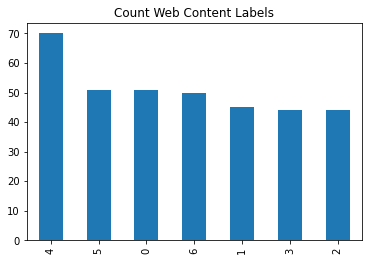

In [13]:
df['encoded_web_content'].value_counts().plot(kind='bar', title='Count Web Content Labels')

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
countvector=CountVectorizer()
df_bow=countvector.fit_transform(corpus).toarray()

In [16]:
print('Shape of Sparse Matrix: ', df_bow.shape)

Shape of Sparse Matrix:  (355, 989)


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = df_bow
y = df['encoded_web_content']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 1,
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=1)
xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6,
              n_estimators=1000, objective='multi:softprob', reg_alpha=0.3,
              silent=False)

In [20]:
xgb_pred = xgb.predict(X_test)

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
print (classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.57      0.67      0.62         6
           2       0.36      0.57      0.44         7
           3       0.90      0.82      0.86        11
           4       0.81      0.81      0.81        16
           5       1.00      0.29      0.44         7
           6       0.86      0.92      0.89        13

    accuracy                           0.77        71
   macro avg       0.79      0.73      0.72        71
weighted avg       0.82      0.77      0.77        71

[[11  0  0  0  0  0  0]
 [ 0  4  2  0  0  0  0]
 [ 0  1  4  1  1  0  0]
 [ 0  0  1  9  0  0  1]
 [ 0  1  1  0 13  0  1]
 [ 0  1  2  0  2  2  0]
 [ 0  0  1  0  0  0 12]]


In [22]:
xgb.feature_importances_

array([0.00808787, 0.        , 0.        , 0.00766451, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00683322, 0.00613962, 0.        , 0.        ,
       0.00551756, 0.        , 0.        , 0.        , 0.     

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [24]:
pd.Series(xgb.feature_importances_)

0      0.008088
1      0.000000
2      0.000000
3      0.007665
4      0.000000
         ...   
984    0.000000
985    0.000000
986    0.000000
987    0.000000
988    0.000000
Length: 989, dtype: float32

In [25]:
countvector.vocabulary_

{'01': 0,
 '02lsq': 1,
 '03': 2,
 '04': 3,
 '05': 4,
 '06': 5,
 '07': 6,
 '08': 7,
 '09': 8,
 '0e5eom6w7ew9wu7wma04tr': 9,
 '10': 10,
 '1000pts': 11,
 '100297': 12,
 '101': 13,
 '1011527': 14,
 '10151315': 15,
 '103167': 16,
 '1033581': 17,
 '10443057': 18,
 '106224': 19,
 '109702': 20,
 '11': 21,
 '1101': 22,
 '1109022': 23,
 '11540': 24,
 '12': 25,
 '1212596': 26,
 '121332': 27,
 '123': 28,
 '1234256': 29,
 '1252759': 30,
 '1266713': 31,
 '12695027': 32,
 '1271974987897831425': 33,
 '127383': 34,
 '1274421': 35,
 '12940137': 36,
 '13': 37,
 '130524': 38,
 '13700007': 39,
 '138640': 40,
 '14283364': 41,
 '14490957': 42,
 '15': 43,
 '157247': 44,
 '162102': 45,
 '1622591': 46,
 '16353407': 47,
 '168933': 48,
 '17034': 49,
 '17093153': 50,
 '17204': 51,
 '1779486': 52,
 '1788': 53,
 '189516': 54,
 '1917576': 55,
 '1969866': 56,
 '199576': 57,
 '1ahie': 58,
 '1bdqam0uc2quiu5k': 59,
 '1rgiufc1fcjcl6b': 60,
 '20': 61,
 '2009': 62,
 '2010': 63,
 '2011': 64,
 '2012': 65,
 '2013': 66,
 '2014'

In [26]:
df2 = pd.DataFrame({"Feature Importance":pd.Series(xgb.feature_importances_)})

In [27]:
df2.head()

,Feature Importance
0,0.008088
1,0.000000
2,0.000000
3,0.007665
4,0.000000


In [28]:
len(countvector.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


989

In [29]:
df2['Vocab'] = countvector.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
df2.sort_values('Feature Importance').tail(20)

,Feature Importance,Vocab
671,0.014071,overflow
770,0.017253,review
253,0.017708,blog
845,0.018087,stackoverflow
697,0.019928,plot
842,0.020802,stack
871,0.021335,tab
667,0.022053,org
518,0.024266,jc3
450,0.025019,githubusercontent


Predictions on 4000 unknown dataset

In [31]:
path = '/content/drive/MyDrive/Colab Notebooks/Dataset/testset_2_UnknownLabels.csv'
df3 = pd.read_csv(path)

In [32]:
df3.tail()

,Unnamed: 0,URL Name
4117,4314,http://web.archive.org/web/20120504045242/http...
4118,4315,https://meta.stackoverflow.com/questions/25200...
4119,4316,https://i.stack.imgur.com/n8M8p.jpg
4120,4318,https://stackoverflow.com/questions/tagged/fac...
4121,4320,https://stackoverflow.com/questions/47818669/d...


In [33]:
corpus2 = []
for i in range(0, len(df3)):
    review = re.sub('[^0-9a-zA-Z]', ' ', df3['URL Name'][i])
    review = review.lower()
    review = review.split()    
    review = [wordNetLemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    #review = [word for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus2.append(review)

In [34]:
corpus2[:5]

['http data stackexchange com stackoverflow query 784562 question without answer filtered',
 'http stackoverflow com question tagged microsoft extension logging',
 'http appscript sourceforge net',
 'http meta stackoverflow com question 252656 punish answerer bad question',
 'http meta stackoverflow com question 333800 suggested edit rejection reason editing post']

In [35]:
df3_bow=countvector.transform(corpus2).toarray()

In [36]:
print('Shape of Sparse Matrix: ', df3_bow.shape)

Shape of Sparse Matrix:  (4122, 989)


In [37]:
xgb_pred2 = xgb.predict(df3_bow)

In [38]:
df3['Predicted Web Content'] = xgb_pred2

In [39]:
df3.head()

,Unnamed: 0,URL Name,Predicted Web Content
0,0,https://data.stackexchange.com/stackoverflow/q...,3
1,1,https://stackoverflow.com/questions/tagged/mic...,3
2,3,http://appscript.sourceforge.net/,2
3,4,https://meta.stackoverflow.com/questions/25265...,3
4,5,https://meta.stackoverflow.com/questions/33380...,3


In [40]:
decoded_web_content = le.inverse_transform(df3['Predicted Web Content'])
df3['Decoded Web Content'] = decoded_web_content

In [41]:
df3.head()

,Unnamed: 0,URL Name,Predicted Web Content,Decoded Web Content
0,0,https://data.stackexchange.com/stackoverflow/q...,3,Question Answers
1,1,https://stackoverflow.com/questions/tagged/mic...,3,Question Answers
2,3,http://appscript.sourceforge.net/,2,Other
3,4,https://meta.stackoverflow.com/questions/25265...,3,Question Answers
4,5,https://meta.stackoverflow.com/questions/33380...,3,Question Answers


In [42]:
df3.to_csv('/content/drive/MyDrive/PredictedWebContenton4000Unknown.csv')

10 fold cross validation

In [43]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(xgb, X, y, scoring='accuracy', cv=10)

In [44]:
scores

array([0.66666667, 0.72222222, 0.83333333, 0.88888889, 0.86111111,
       0.88571429, 0.88571429, 0.74285714, 0.71428571, 0.45714286])

In [45]:
scores.mean()

0.7657936507936508

Predictions on Top 100 URLs

In [45]:
#/content/drive/MyDrive/Colab Notebooks/Dataset/testset_top100_url_webcontent.csv

In [47]:
path = '/content/drive/MyDrive/Colab Notebooks/Dataset/testset_top100_url_webcontent.csv'
df4 = pd.read_csv(path)

In [48]:
df4.tail()

,Unnamed: 0,Unnamed: 0.1,URL Name,URL Sub Domain,URL Domain,Repetition
95,6002,6002,https://stackoverflow.com/questions/tagged/string,NaN,stackoverflow.com,48
96,9733,9733,https://stackoverflow.com/questions/tagged/css3,NaN,stackoverflow.com,47
97,3111,3111,http://creativecommons.org/licenses/by-sa/3.0/,NaN,creativecommons.org,47
98,1051,1051,https://stackoverflow.com/help/privileges/crea...,NaN,stackoverflow.com,47
99,3549,3549,https://stackoverflow.com/reputation,NaN,stackoverflow.com,47


In [49]:
corpus3 = []
for i in range(0, len(df4)):
    review = re.sub('[^0-9a-zA-Z]', ' ', df4['URL Name'][i])
    review = review.lower()
    review = review.split()    
    review = [wordNetLemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    #review = [word for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus3.append(review)

In [50]:
corpus3[:5]

['http stackoverflow com help topic',
 'http stackoverflow com help mcve',
 'http stackoverflow com help ask',
 'http stackoverflow com question tagged java',
 'http stackoverflow com question tagged javascript']

In [51]:
df4_bow=countvector.transform(corpus3).toarray()

In [52]:
print('Shape of Sparse Matrix: ', df4_bow.shape)

Shape of Sparse Matrix:  (100, 989)


In [53]:
xgb_pred3 = xgb.predict(df4_bow)

In [54]:
df4['Predicted Web Content'] = xgb_pred3

In [55]:
df4.head()

,Unnamed: 0,Unnamed: 0.1,URL Name,URL Sub Domain,URL Domain,Repetition,Predicted Web Content
0,924,924,https://stackoverflow.com/help/on-topic,NaN,stackoverflow.com,574,1
1,122,122,https://stackoverflow.com/help/mcve,NaN,stackoverflow.com,557,1
2,1358,1358,https://stackoverflow.com/help/how-to-ask,NaN,stackoverflow.com,461,1
3,1287,1287,https://stackoverflow.com/questions/tagged/java,NaN,stackoverflow.com,461,3
4,1291,1291,https://stackoverflow.com/questions/tagged/jav...,NaN,stackoverflow.com,435,3


In [56]:
decoded_web_content_100 = le.inverse_transform(df4['Predicted Web Content'])
df4['Decoded Web Content'] = decoded_web_content_100

In [57]:
df4.head()

,Unnamed: 0,Unnamed: 0.1,URL Name,URL Sub Domain,URL Domain,Repetition,Predicted Web Content,Decoded Web Content
0,924,924,https://stackoverflow.com/help/on-topic,NaN,stackoverflow.com,574,1,Opinion/Specialty
1,122,122,https://stackoverflow.com/help/mcve,NaN,stackoverflow.com,557,1,Opinion/Specialty
2,1358,1358,https://stackoverflow.com/help/how-to-ask,NaN,stackoverflow.com,461,1,Opinion/Specialty
3,1287,1287,https://stackoverflow.com/questions/tagged/java,NaN,stackoverflow.com,461,3,Question Answers
4,1291,1291,https://stackoverflow.com/questions/tagged/jav...,NaN,stackoverflow.com,435,3,Question Answers


In [58]:
df4.to_csv('/content/drive/MyDrive/PredictedWebContentonTop100URLsUnknown.csv')